# PyMMM: Python Mother Machine Manager

In [1]:
import os
import numpy as np
from PIL import Image
from joblib import Parallel, delayed
from tqdm.auto import tqdm
from itertools import product
import zarr
from numcodecs import Blosc
from PyMMM_main.Experiment.experiment_z_stack import Experiment

In [2]:
os.getcwd()

'd:\\PRISM'

In [3]:

import os
# os.environ["JOBLIB_TEMP_FOLDER"] = "C:/temp"
# os.makedirs("C:/temp", exist_ok=True)
os.makedirs("D:/temp", exist_ok=True)
os.environ["JOBLIB_TEMP_FOLDER"] = "D:/temp"


The first thing to do is to define your experiment's directory, and instantite an `Experiment` object using that directory.
Let's also print the experiment's properties

In [4]:

directory = os.getcwd()
# Specify the extracted directory you want to use
extracted_directory = os.path.join(directory, "extracted_leaknuc", "extracted_z00")

my_experiment = Experiment(
    directory,
    save_filetype="png",
    extracted_dir=extracted_directory
)
print(my_experiment)



            Experiment name: PRISM
            Channels: ['BFP', 'CFP', 'PC', 'RFP', 'mVenus']
            Timepoints: 1
            FOVs: 10
            Registered: True
        


d:\PRISM\PyMMM_main\Experiment\experiment_z_stack.py:114: UserWarning: No mean_amount attribute set. Taking image means over all timepoints. Very slow!
  warnings.warn("No mean_amount attribute set. Taking image means over all timepoints. Very slow!")


Here, we can choose the times and FOVs to take forward for registration

In [5]:
my_experiment.set_analysis_times(0, 1)
#my_experiment.discard_FOVs([f"xy0{str(x).zfill(2)}" for x in range(30, 37)]) 

In [6]:
my_experiment.FOVs

['xy000',
 'xy001',
 'xy002',
 'xy003',
 'xy004',
 'xy005',
 'xy006',
 'xy007',
 'xy008',
 'xy009']

In [7]:
# # Manually set the channel order based on the acquisition order in the metadata
# my_experiment.channels = ['PC', 'CFP', 'mVenus', 'mCherry3', 'Dapi']

### Let's now ensure the quality of the data

We're going to register the images to minimise the effects of stage drift.

* First we will set the experiment's registration channel, here we are using `"PC"` for phase contrast.

In [8]:
my_experiment.registration_channel = "PC"
# my_experiment.registration_channel = "BF"

Next we will do two things:
* The first is to calculate mean images for the experiment. These are average images which will be used for image registration
* By default, PyMMM takes an average over the last 15 images of the experiment, as the experiment's stage drift has likely stopped by then.
* We can also rotate the mean image if the experiment was not properly aligned. This will rotate the mean images, and all other images will be registered against them, rotating them in the process.
* Let's just check our experiment without the rotation argument.

In [9]:
my_experiment.mean_amount = 200

  0%|          | 0/10 [00:00<?, ?it/s]

Mean images for 10 FOVs with rotation of 0 deg calculated, use the mean_images method to return a dict of mean images


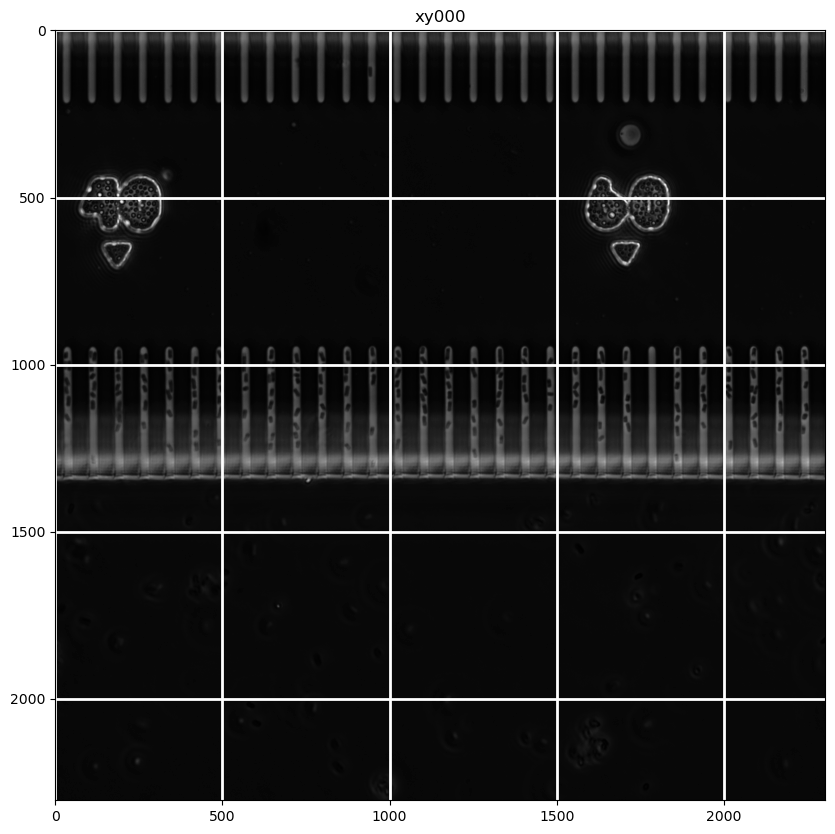

In [10]:
my_experiment.get_mean_images(plot = True)

If there's some rotation in our experiment, rotate the images and recalculate the mean images. The rotated angle should be indicated in the output of the previous cell.

In [96]:
# my_experiment.get_mean_images(rotation = 180.2, plot = True)

In [11]:
my_experiment.rotation

0

That's looking much better.
This function below call aligns all images in the experiment to a specific timepoint (5th) using the registration channel, applying the alignment only within the specified pixel limits.
* We can now register the images. We only need to do this once, so we can check whether the experiment has already been registered with the `is_registered` property.
* Here we check if an experiment is registered, and not, we register it with all of our CPU cores.
* There is also a `force` argument, which if set to `True` will overwrite any previous registered images.

In [12]:
if my_experiment.is_registered:
    print("Experiment is already registered. Skip registration step.")
else:
    print("Experiment is not registered, please run the cell below")


Experiment is already registered. Skip registration step.


In [13]:
my_experiment.registered_dir

'd:\\PRISM\\registered\\'

In [14]:
my_experiment.FOVs

['xy000',
 'xy001',
 'xy002',
 'xy003',
 'xy004',
 'xy005',
 'xy006',
 'xy007',
 'xy008',
 'xy009']

In [ ]:
# Specify the FOVs you want to register
# Assuming FOVs are named like 'xy000', 'xy001', ..., 'xy010'
selected_FOVs = [f'xy{str(i).zfill(3)}' for i in range(0, 6)]
# selected_FOVs = ['xy000']
my_experiment.FOVs = [fov for fov in my_experiment.FOVs if fov in selected_FOVs]

my_experiment.FOVs = selected_FOVs


# # Now run the registration only on these FOVs
my_experiment.register_experiment(force=True, mode=0, sum=False, n_jobs=-1, y_lims=(0,1500), x_lims=(0, -1))


In [17]:
import shutil
total, used, free = shutil.disk_usage("D:/")
print(f"Free space: {free // (1024**3)} GB")


Free space: 270 GB


In [103]:
# takes like 30 mins, register all
# my_experiment.register_experiment(force=True, mode=0, sum=False, n_jobs = -1,  y_lims = (400,1000), x_lims = (0,-1))
# # my_experiment.register_experiment(force=True, mode=0, sum=False, n_jobs = -1,  y_lims = (250,900), x_lims = (0,-1))

### Let's now find the trenches

There are several methods you can use to explore the experiment:

Channels: ['BFP', 'GFP', 'PC', 'RFP']

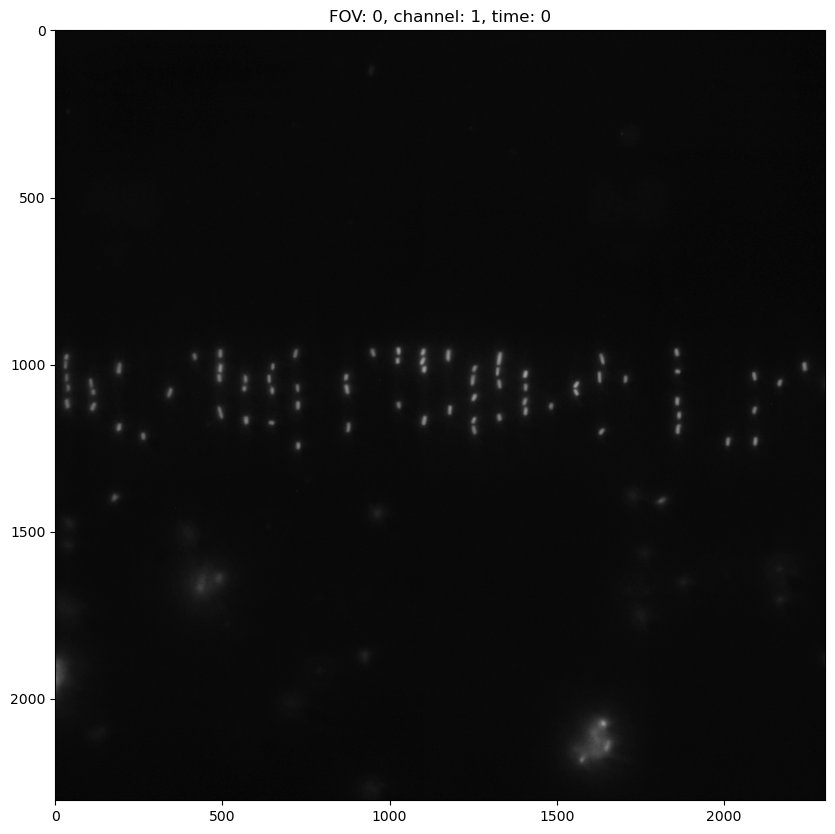

(2304, 2304)

In [18]:
#Indexing using numbers
an_image = my_experiment.get_image(FOV = 0, channel = 1, time = 0, plot = True, registered = True)
an_image.shape
#Indexing using channel and FOV names
#an_image = my_experiment.get_image(FOV = "A23", channel = "Green", time = 1, plot = True, registered = True)

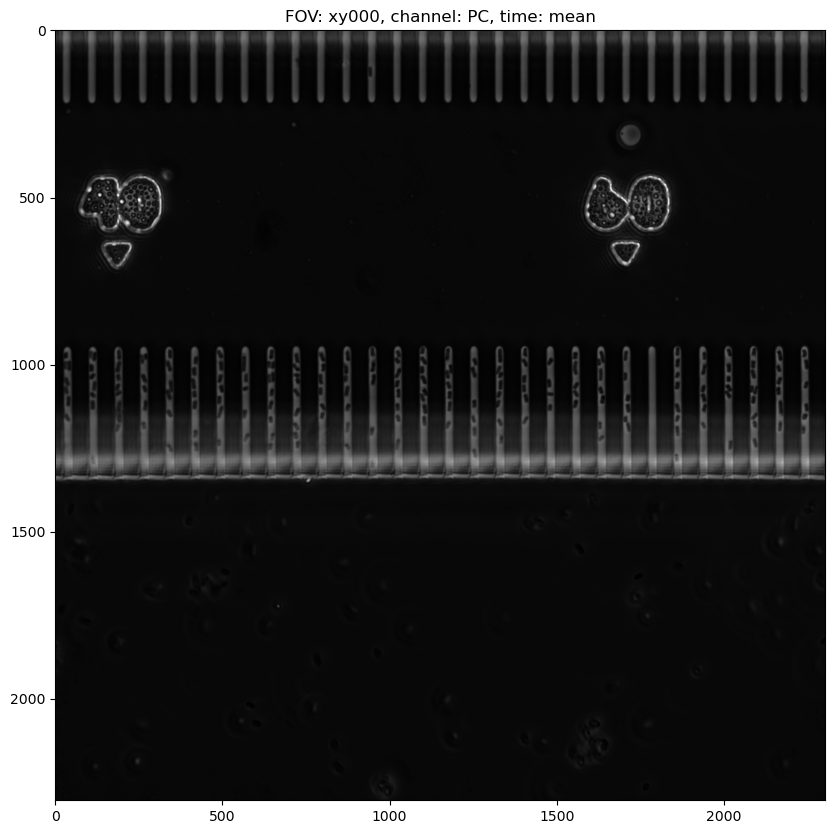

In [22]:
#Getting the mean of a timestack for a particular FOV
a_mean_image = my_experiment.get_mean_of_timestack(0, 2, plot=True)

In [20]:
mean_timestacks = [my_experiment.get_mean_of_timestack(FOV, "PC", ) for FOV in my_experiment.FOVs]
#mean_timestacks = [my_experiment.get_mean_of_timestack(FOV, "BF", ) for FOV in my_experiment.FOVs]

### If there are two rows of trenches in the image
We need to crop one row at a time.


In [21]:
# if there are two rows of trenches, crop each row. if there is only one row, can set to None
# x_crop = (200, 2000)
y_crop = (800,1500)

### Finding the x limits

In [23]:
my_experiment.registration_channel

'PC'

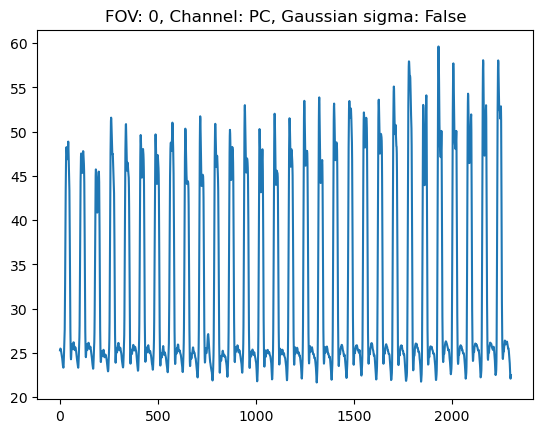

In [24]:
# Getting the mean of the timestack over the x direction
a_t_x_mean = my_experiment.mean_t_x(0, my_experiment.registration_channel, y_crop=y_crop, plot=True)


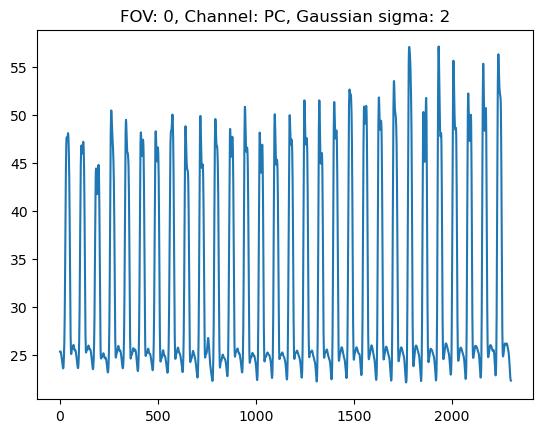

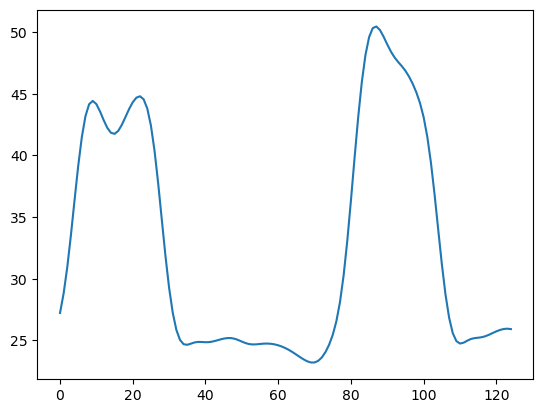

In [25]:
# Adding a gaussian blurring using the sigma argument
# This sigma should be similar to the size of trench
from copy import deepcopy
import matplotlib.pyplot as plt

sigma = 2

# Use a convolution filter if gaussian blurring isn't working well
a_t_x_mean = my_experiment.mean_t_x(0, my_experiment.registration_channel, sigma=sigma, y_crop=y_crop, plot=True)
f = deepcopy(a_t_x_mean[175:300])
plt.plot(f)


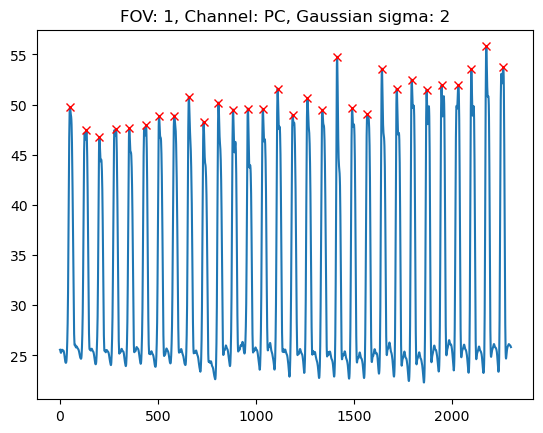

(2304, 2304)


In [26]:
# Now finding trench peaks for a particular FOV, giving a distance argument, and using our sigma value from before

# When detecting peaks, the algorithm will ensure that each identified peak is at least distance=100 pixels away from the next peak.
# By setting prominence=10, the algorithm will only consider peaks that are at least 10 units taller than their surrounding area.
distance = 20
prominence = 4

# if you want to use convolutional filter, set conv_filter to f. This is often done for MM with side trenches for phage experiments.
peaks = my_experiment.find_trench_peaks(1, 
                                        my_experiment.registration_channel, 
                                        sigma=sigma, 
                                        distance=distance, 
                                        prominence=prominence, 
                                        conv_filter=None,
                                        y_crop=y_crop, 
                                        plot=True)
print(my_experiment.dims)


We've found good values for `sigma` and `distance`.
Let's now call `find_all_trench_x_positions` on the phase contrast channel to identify all the x limits of the trenches in every FOV

In [27]:
trench_x_positions = my_experiment.find_all_trench_x_positions(my_experiment.registration_channel, 
                                                               sigma=sigma, 
                                                               distance=distance, 
                                                               prominence=prominence, 
                                                               conv_filter=None, 
                                                               trench_width=60,
                                                               y_crop=y_crop, 
                                                               plot=False, 
                                                               plot_save=True)

# shrink_scale = 2.0: The width of the trench is set to be half of the average distance between the detected peaks.
# shrink_scale = 4.0: The width is one-quarter of the distance between peaks, effectively making the trenches narrower.
# shrink_scale=2,


Using the trench width specified by trench_width. Please ensure this parameter is an appropriate integer


### Discard any bad trenches

In [114]:
#my_experiment.discard_trenches(list(range(943, 947)))

### Finding the y limits
So we've successfully found the x limits of the trenches. Let's now find the y limits.
Change sigma and height parameters until you see cross (x) in where you want.

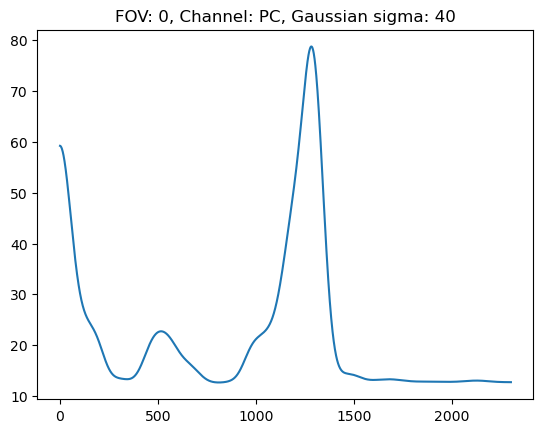

In [28]:
#Adding a gaussian blurring using the sigma argument
sigma = 40
a_t_y_mean = my_experiment.mean_t_y(0, my_experiment.registration_channel, sigma = sigma, plot = True)

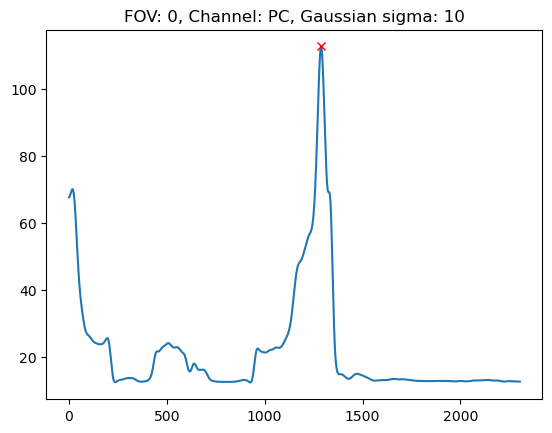

In [29]:
#Adding a gaussian blurring using the sigma argument
sigma = 10
height = 20
distance = my_experiment.dims[0]
a_t_y_mean, y_peak = my_experiment.find_lane_peaks(0, sigma = sigma, distance = distance, height=height, plot = True, y_crop=y_crop)

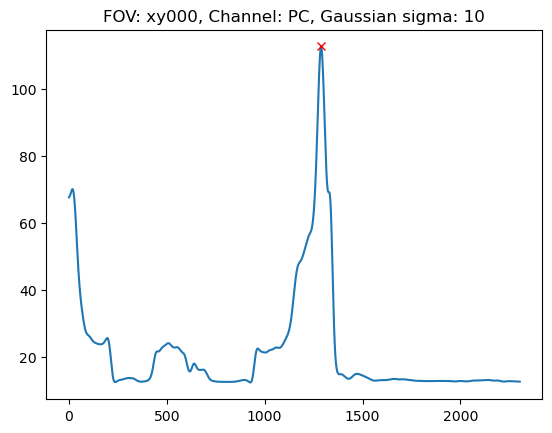

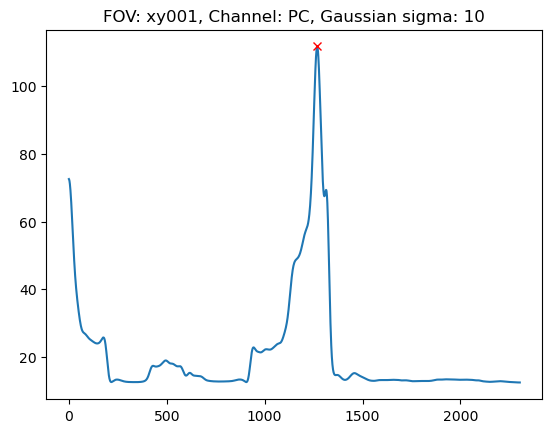

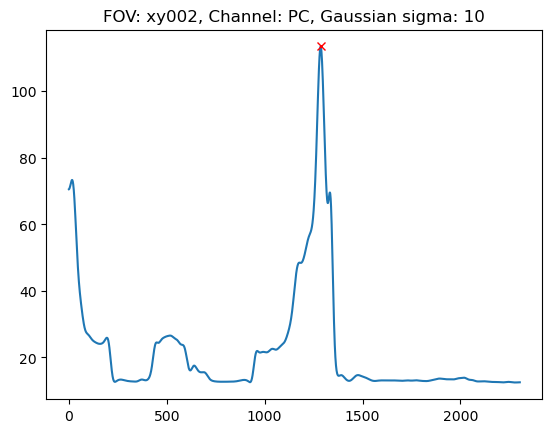

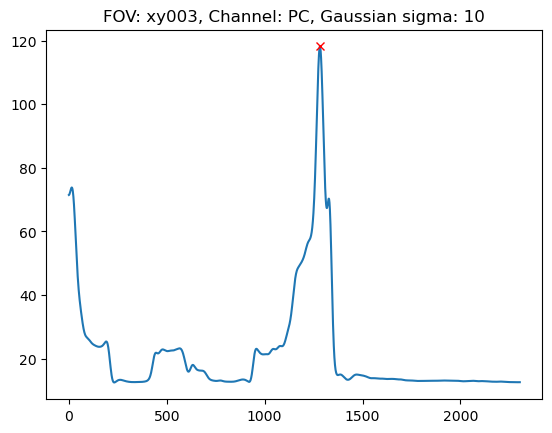

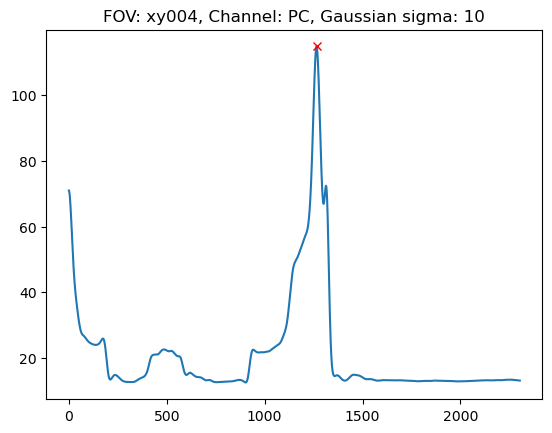

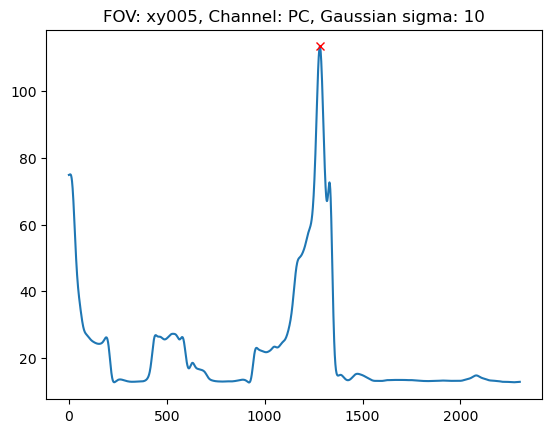

In [30]:
y_peaks = {FOV: my_experiment.find_lane_peaks(FOV, sigma=sigma, distance=distance, height=height, plot=True, y_crop=y_crop)[1] for FOV in my_experiment.FOVs}

Set the y offsets from the halo (knowing the trench length can be helpful here)

In [31]:
# you need to play with this values to get trenches in frame
# if you set trench_y_offsets = (300, 20), the extracted trench would cover 300 up from halo, 20 up from halo detected
# my_experiment.trench_y_offsets = (200, 135)
my_experiment.trench_y_offsets = (380, 120)

Check that only one y peak has been found for each FOV

In [32]:
y_peaks

{'xy000': array([1288], dtype=int64),
 'xy001': array([1268], dtype=int64),
 'xy002': array([1286], dtype=int64),
 'xy003': array([1282], dtype=int64),
 'xy004': array([1265], dtype=int64),
 'xy005': array([1282], dtype=int64)}

Find the y limits

In [33]:
y_peaks = my_experiment.find_all_trench_y_positions_PC(channel=my_experiment.PC_channel,sigma=sigma,distance=distance,height=height,plot=False, plot_save=True, y_crop=y_crop)

### Extract the trenches as png (change z)

In [ ]:
# Finally, extract the trenches.
# Here, we loop over all FOV, channel, and time combinations and save with z=0.
fields = product(my_experiment.FOVs, my_experiment.channels, my_experiment.times)
for FOV, channel, time in fields:
    my_experiment.get_trenches(FOV, channel, time, z=1, save=True)

### (After extracting for all z) Choose sharp image

In [ ]:
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import laplace
from PIL import Image
from collections import defaultdict

# --- Settings ---
# The folder containing your extracted trench images
trench_folder = r"D:\PRISM\trenches"

# Example pattern for one trench; adjust as needed:
# Files are named like: xy004_PC_TR00_Z00_TTT0000.png, xy004_PC_TR00_Z01_TTT0000.png, etc.
pattern = os.path.join(trench_folder, "xy001_*_TR05_Z*_T0000.png")

# Gather all matching files
files = sorted(glob.glob(pattern))
if not files:
    raise ValueError("No files found matching pattern: " + pattern)
else:
    print("Found the following files:")
    for f in files:
        print(f)

# --- Group files by channel ---
# We assume the file name is split by underscores and the channel is the second element
channel_files = defaultdict(list)
for f in files:
    base = os.path.basename(f)
    parts = base.split('_')
    if len(parts) < 5:
        print(f"Filename {base} does not have the expected parts.")
        continue
    channel = parts[1]  # e.g. "PC"
    channel_files[channel].append(f)

# --- Process each channel ---
best_focus_images = {}  # To store best focused file for each channel

for ch, flist in channel_files.items():
    print(f"\nProcessing channel: {ch}")
    best_var = -np.inf
    best_file = None
    z_positions = []
    focus_vars = []
    images = []  # list to hold image arrays for plotting

    # Loop over every file (each corresponding to a different z–slice)
    for f in flist:
        # Load the image (as grayscale, if appropriate)
        img = np.array(Image.open(f))
        images.append(img)
        
        # Compute the Laplacian of the image to act as an edge detector
        lap_img = laplace(img)
        # Use the variance of the Laplacian as a focus metric
        var_val = np.var(lap_img)
        focus_vars.append(var_val)
        
        # Parse the z–slice number from the filename.
        # We assume one of the underscore–separated parts starts with "Z", e.g., "Z00"
        base = os.path.basename(f)
        parts = base.split('_')
        z_strs = [p for p in parts if p.startswith("Z")]
        if z_strs:
            try:
                z_val = int(z_strs[0][1:])  # remove "Z" and convert to int
            except ValueError:
                z_val = 0
        else:
            z_val = 0
        z_positions.append(z_val)
        
        # Keep track of the best (highest variance) image
        if var_val > best_var:
            best_var = var_val
            best_file = f

    best_focus_images[ch] = best_file

    # --- Plot all images for this channel ---
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(4 * num_images, 4))
    # If there is only one image, wrap axes in a list so that we can iterate uniformly.
    if num_images == 1:
        axes = [axes]
    for ax, img, z, var_val in zip(axes, images, z_positions, focus_vars):
        ax.imshow(img, cmap="gray")
        ax.set_title(f"Z={z}\nVar={var_val:.2f}")
        ax.axis("off")
    fig.suptitle(f"All images for channel {ch}")
    plt.tight_layout()
    plt.show()

    # --- Plot focus metric (variance vs z-position) ---
    plt.figure(figsize=(6, 4))
    plt.plot(z_positions, focus_vars, marker='o', linestyle='-')
    plt.xlabel("Z position")
    plt.ylabel("Laplacian Variance")
    plt.title(f"Focus Metric for Channel {ch}")
    plt.grid(True)
    plt.show()

    print(f"Channel {ch}: Best focused image is:\n  {best_file}\nwith variance {best_var:.2f}\n")

# Optionally, you can now process the best_focus_images further


i have a feeling that I should take PC focus as a benchmark

save the best focused image as zarr array

In [ ]:
import os
import glob
import numpy as np
from skimage.filters import laplace
from PIL import Image
import shutil

# --- Parameters ---
# Folder where all the trench images are currently saved.
trench_folder = r"D:\PRISM\trenches"
# Folder to save the best–focused images
output_folder = r"D:\PRISM\trenches_best"
os.makedirs(output_folder, exist_ok=True)

# --- Gather all PNG files in the trench folder ---
all_files = glob.glob(os.path.join(trench_folder, "*.png"))
print(f"Found {len(all_files)} files in {trench_folder}")

# --- Group files by (FOV, trench, time) ---
# We assume the file name structure is:
#   {FOV}_{channel}_{trench}_{z}_{time}.png
# For example: xy004_PC_TR00_Z00_TTT0000.png
groups = {}
for filepath in all_files:
    base = os.path.basename(filepath)
    parts = base.split('_')
    if len(parts) < 5:
        print(f"Skipping file with unexpected name format: {base}")
        continue
    # Parse the parts:
    fov     = parts[0]            # e.g., "xy004"
    channel = parts[1]            # e.g., "PC" or "DAPI" etc.
    trench  = parts[2]            # e.g., "TR00"
    z_part  = parts[3]            # e.g., "Z00"
    time_part = parts[4]          # e.g., "TTT0000.png"
    time_str = os.path.splitext(time_part)[0]  # remove extension, gives "TTT0000"

    # Use (fov, trench, time_str) as the group key.
    key = (fov, trench, time_str)
    if key not in groups:
        # Each group is a dictionary mapping channel to another dict mapping z to filename.
        groups[key] = {}
    if channel not in groups[key]:
        groups[key][channel] = {}
    # Parse the z–value: assume z_part starts with 'Z'
    try:
        z_val = int(z_part[1:])
    except Exception as e:
        print(f"Could not parse z value from {z_part} in file {base}: {e}")
        continue
    groups[key][channel][z_val] = filepath

print(f"Found {len(groups)} groups (unique FOV/trench/time combinations).")

# --- Define a focus metric function ---
def focus_metric(image_array):
    """
    Compute the focus metric for an image as the variance of its Laplacian.
    (Higher variance should indicate sharper edges and better focus.)
    """
    lap = laplace(image_array)
    return np.var(lap)

# --- Process each group ---
# For each group, we use the PC channel to decide the best z.
# Then, for every channel in that group, we select the image at the chosen z and copy it to output.
for group_key, channel_dict in groups.items():
    fov, trench, time_str = group_key

    if "PC" not in channel_dict:
        print(f"Group {group_key} has no PC channel; skipping group.")
        continue

    # For the PC channel, compute the focus metric for each z
    pc_files = channel_dict["PC"]
    best_z = None
    best_focus = -np.inf
    for z_val, filepath in pc_files.items():
        try:
            # Open image (we assume grayscale; if color, consider converting)
            img = np.array(Image.open(filepath))
        except Exception as e:
            print(f"Error loading {filepath}: {e}")
            continue
        metric = focus_metric(img)
        if metric > best_focus:
            best_focus = metric
            best_z = z_val

    if best_z is None:
        print(f"Could not determine best z for group {group_key}; skipping.")
        continue

    print(f"Group {group_key}: best z for PC is {best_z} with focus metric {best_focus:.2f}")

    # For every channel in this group, select the image at best_z (if available)
    for channel, z_files in channel_dict.items():
        if best_z not in z_files:
            print(f"Group {group_key}: channel {channel} does not have an image at z = {best_z}; skipping channel.")
            continue
        src = z_files[best_z]
        # Create a new filename reflecting the chosen z–slice.
        # Here the new filename will be: {fov}_{channel}_{trench}_Z{best_z:02d}_TT{time_str}.png
        new_filename = f"{fov}_{channel}_{trench}_Z{best_z:02d}_{time_str}.png"
        dst = os.path.join(output_folder, new_filename)
        try:
            # Option 1: Simply copy the file if no modification is needed.
            shutil.copy(src, dst)
            # Option 2: Alternatively, open and re-save (uncomment if needed)
            # img = Image.open(src)
            # img.save(dst)
        except Exception as e:
            print(f"Error saving file {dst}: {e}")

print("Processing complete. Check the output folder:", output_folder)


### turn png into zarr

In [38]:
import os
import glob
import numpy as np
from PIL import Image
import zarr
from numcodecs import Blosc

# ---------------------------
# Settings and paths:
# ---------------------------
# Folder where your best-focused trench images are saved.
best_folder = r"D:\PRISM\trenches_best"
# Output zarr file (the new zarr array will be written here)
zarr_path = r"D:\PRISM\trenches_best.zarr"

# ---------------------------
# 1. Get list of all files and parse filenames.
# ---------------------------
# We assume each filename has the format:
#    {FOV}_{channel}_TR{trench:02d}_Z{z:02d}_TTT{time}.png
all_files = glob.glob(os.path.join(best_folder, "*.png"))
if not all_files:
    raise ValueError("No PNG files found in " + best_folder)

# Initialize sets and list for file information
fov_set = set()
channel_set = set()
time_set = set()
# We will also record per-FOV which trench numbers appear.
fov_trench_dict = {}

# List to hold tuples: (filepath, FOV, channel, local_trench, z_val, time)
filenames_info = []
for filepath in all_files:
    base = os.path.basename(filepath)
    parts = base.split('_')
    if len(parts) < 5:
        print("Skipping unexpected filename:", base)
        continue
    fov = parts[0]            # e.g., "xy004"
    channel = parts[1]        # e.g., "PC"
    trench_str = parts[2]     # e.g., "TR00"
    try:
        local_trench = int(trench_str.replace("TR", ""))
    except Exception as e:
        print("Could not parse trench from", trench_str, ":", e)
        continue
    z_str = parts[3]          # e.g., "Z00" (we don’t use z here since the file is already best focused)
    try:
        z_val = int(z_str.replace("Z", ""))
    except Exception as e:
        print("Could not parse z from", z_str, ":", e)
        continue
    time_str = os.path.splitext(parts[4])[0]  # e.g., "TTT0000"
    
    fov_set.add(fov)
    channel_set.add(channel)
    time_set.add(time_str)
    fov_trench_dict.setdefault(fov, set()).add(local_trench)
    filenames_info.append((filepath, fov, channel, local_trench, z_val, time_str))

# ---------------------------
# 2. Build sorted lists and a global mapping for (FOV, local trench)
# ---------------------------
fov_list = sorted(list(fov_set))
channel_list = sorted(list(channel_set))
time_list = sorted(list(time_set))
# Build per-FOV sorted list for trench numbers
for f in fov_trench_dict:
    fov_trench_dict[f] = sorted(list(fov_trench_dict[f]))

# Create a global mapping so that each (FOV, local_trench) gets a unique index.
# We assume here that the order is FOV-sorted and then, within each FOV, trenches are sorted.
trench_index_mapping = {}
global_trench = 0
for fov in sorted(fov_trench_dict.keys()):
    for local_trench in fov_trench_dict[fov]:
        trench_index_mapping[(fov, local_trench)] = global_trench
        global_trench += 1
n_trenches = global_trench
print("Total number of global trenches:", n_trenches)
print("FOVs:", fov_list)
print("Channels:", channel_list)
print("Times:", time_list)

# ---------------------------
# 3. Determine image size.
# ---------------------------
# Load one sample image to determine (height, width)
sample_img = np.array(Image.open(all_files[0]))
trench_y_size, trench_x_size = sample_img.shape
print("Trench image size:", trench_y_size, trench_x_size)

# ---------------------------
# 4. Open a zarr array for the output.
# ---------------------------
compressor = Blosc(cname='zstd', clevel=9, shuffle=Blosc.BITSHUFFLE)
# We assume each global trench will have one best-focused image per (time, channel)
z_shape = (n_trenches, len(time_list), len(channel_list), trench_y_size, trench_x_size)
z1 = zarr.open(zarr_path, mode='w', shape=z_shape,
               chunks=(1, 1, 1, trench_y_size, trench_x_size),
               dtype='uint16', compressor=compressor)
print("Opened zarr array with shape:", z1.shape)

# ---------------------------
# 5. Loop over all files and fill the zarr array.
# ---------------------------
for info in filenames_info:
    filepath, fov, channel, local_trench, z_val, time_str = info
    try:
        t_index = time_list.index(time_str)
    except ValueError:
        print("Time", time_str, "not found in time_list")
        continue
    try:
        c_index = channel_list.index(channel)
    except ValueError:
        print("Channel", channel, "not found in channel_list")
        continue
    global_index = trench_index_mapping.get((fov, local_trench))
    if global_index is None:
        print("No mapping for", fov, "trench", local_trench)
        continue
    try:
        img = np.array(Image.open(filepath))
    except Exception as e:
        print("Error loading", filepath, ":", e)
        continue
    if img.shape != (trench_y_size, trench_x_size):
        print(f"Warning: image {filepath} has shape {img.shape}, expected ({trench_y_size}, {trench_x_size})")
    z1[global_index, t_index, c_index] = img

print("Zarr array successfully filled and saved at:", zarr_path)


Total number of global trenches: 180
FOVs: ['xy000', 'xy001', 'xy002', 'xy003', 'xy004', 'xy005']
Channels: ['BFP', 'CFP', 'PC', 'RFP', 'mVenus']
Times: ['T0000']
Trench image size: 260 60
Opened zarr array with shape: (180, 1, 5, 260, 60)
Zarr array successfully filled and saved at: D:\PRISM\trenches_best.zarr


In [131]:
print(f"Loaded image dtype: {img.dtype}")


Loaded image dtype: uint16


merge arrays

In [ ]:
# import zarr
# from numcodecs import Blosc

# # Define paths to the input Zarr arrays and the output merged array.
# zarr_path1 = r"D:\PRISM\trenches_best.zarr"
# zarr_path2 = r"D:\PRISM\trenches_best_redmemexp1.zarr"
# merged_zarr_path = r"D:\PRISM\trenches_best_redmemexp.zarr"

# # Open the two Zarr arrays in read mode.
# z1 = zarr.open(zarr_path1, mode='r')
# z2 = zarr.open(zarr_path2, mode='r')

# # Check that the two arrays have matching shapes for axes 1 and beyond.
# if z1.shape[1:] != z2.shape[1:]:
#     raise ValueError("The two Zarr arrays have different shapes (except axis 0). Cannot merge.")

# # Compute the merged shape along axis 0.
# merged_shape = (z1.shape[0] + z2.shape[0],) + z1.shape[1:]
# print("Merged shape:", merged_shape)

# # Create a compressor (using Blosc with zstd).
# compressor = Blosc(cname='zstd', clevel=9, shuffle=Blosc.BITSHUFFLE)

# # Create a new Zarr array for the merged data.
# # We use the same chunk size as z1 (assumed to be compatible with z2).
# merged_z = zarr.open(merged_zarr_path, mode='w',
#                      shape=merged_shape,
#                      chunks=z1.chunks,
#                      dtype=z1.dtype,
#                      compressor=compressor)

# # Copy data from z1 (global trenches 0 to z1.shape[0]-1)
# merged_z[:z1.shape[0]] = z1[:]

# # Copy data from z2 (global trenches z1.shape[0] to end)
# merged_z[z1.shape[0]:] = z2[:]

# print("Merged Zarr array successfully saved to:", merged_zarr_path)


Merged shape: (1257, 1, 2, 110, 30)
Merged Zarr array successfully saved to: D:\PRISM\trenches_best_redmemexp.zarr


### Visualise zarr trench image

In [39]:
my_experiment.channels

['BFP', 'CFP', 'PC', 'RFP', 'mVenus']

In [ ]:
# import os
# import zarr
# import numpy as np

# # 1. Define paths and open the Zarr
# basedir = os.getcwd()
# zarr_path = os.path.join(basedir, 'trenches_best.zarr')

# # Open in read+write mode
# z1 = zarr.open(zarr_path, mode='r+')

# # 2. Define current vs desired channel order
# current_order = ['BFP', 'CFP', 'PC', 'RFP', 'mVenus']
# desired_order = ['PC', 'CFP', 'RFP', 'mVenus', 'BFP']

# # 3. Compute reorder indices
# reorder_indices = [current_order.index(ch) for ch in desired_order]

# # 4. Read and reorder the data along the channel axis (axis=2)
# #    This will create a full in-memory copy of the zarr array, so make sure you
# #    have enough RAM. If not, you can iterate chunk-by-chunk instead.
# print("Loading and reordering trenches.zarr in memory...")
# reordered = np.take(z1[:, :, :, :, :], indices=reorder_indices, axis=2)

# # 5. Write the reordered data back into the original Zarr
# print("Writing reordered data back to trenches.zarr...")
# z1[:, :, :, :, :] = reordered

# print("✔ Channel axis has been reordered to:", desired_order)


Loading and reordering trenches.zarr in memory...
Writing reordered data back to trenches.zarr...
✔ Channel axis has been reordered to: ['PC', 'CFP', 'RFP', 'mVenus', 'BFP']


In [45]:
z1 = zarr.open('trenches_best_rednucexp.zarr', mode='r')

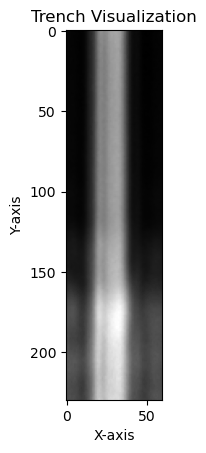

In [275]:
# Visualise one of the zarr array trenches
# Example: Visualize the first trench, first time point, and first channel
trench_data = z1[17, 0, 1]

plt.imshow(trench_data, cmap='gray')
plt.title("Trench Visualization")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()


In [132]:
import napari

# Assuming z1 is your Zarr dataset
viewer = napari.Viewer()

# Add the Zarr data to the viewer
viewer.add_image(z1, name='Trench Data')

# Start the napari viewer
napari.run()


### Save trench zarr metadata to json files
Aim here is to create a loadable mapping from the trench zarr indices to the information which was available prior to extraction. Three json files are created. When loaded back as a dictionary, the key of the dictionary corresponds to the relevant index of the trench zarr.
* A mapping from zarr trench number -> FOV
* A mapping from zarr timepoint -> experiment time point (could be a useful record if any time points were discarded)
* A mapping from zarr channel index -> channel string

In [371]:
import json

In [372]:
# Mapping of FOV to trenchID
trench_num = 0
FOV_to_trench_dict = dict()
for FOV in my_experiment.FOVs:
    y_pos = my_experiment.y_peaks[FOV][0]
    x_pos = my_experiment.pruned_experiment_trench_x_lims[FOV]
    FOV_to_trench = []
    if type(x_pos) == dict:
        for key, value in x_pos.items():
            FOV_to_trench.append(trench_num)
            trench_num += 1
    else:
        for i, (L, R) in enumerate(x_pos):
            FOV_to_trench.append(trench_num)
            trench_num += 1
    FOV_to_trench_dict[FOV] = FOV_to_trench

In [ ]:
### invert the mapping, i.e index in zarr array is a dict key which maps to experimental metadata
# mapping of trench ID to FOV
trench_to_FOV_dict = dict()
for key, value in FOV_to_trench_dict.items():
    for tr in value:
        trench_to_FOV_dict[tr] = key
trench_to_FOV_dict

In [374]:
# The dictionary trench_to_FOV_dict (created above) is saved into this file as a JSON object.
# nd2_file = "Barcoding_HADA_DAPI_40x_T1_1.nd2" # could be imported from nd2 metadata json
# nd2_file = "20241023_SB8_FDAA.nd2"
# nd2_file = "HADA_W1_7_T_singledye.nd2"
# nd2_file = "Barcoding_HADA_40x_T1.nd2"
# nd2_file = "Barcoding_DAPI_40x_T1.nd2"
#nd2_file = "Barcoding_HADA_DAPI_40x_T1_1.nd2"

# nd2_file ="20241108_RADA.nd2"
# nd2_file = "20241114_Leakage.nd2"
nd2_file = "20241205_nucleoid2.nd2"
# nd2_file = "20241207_membrane.nd2"
# nd2_file = "20241208_membrane_nucleoid.nd2"

file = "metadata_trench_zarr_FOVs_" + nd2_file + ".json"
with open(file, 'w') as f: 
    json.dump(trench_to_FOV_dict, f)

In [376]:
# Saves metadata about the channels, linking channel indices to names. This is important when interpreting the Zarr data where channels might be indexed numerically.
channel_info_dict = dict()
for count, channel in enumerate(my_experiment.channels):
    channel_info_dict[str(count)] = channel
    
file = "metadata_trench_zarr_channels_" + nd2_file + ".json"
with open(file, 'w') as f: 
    json.dump(channel_info_dict, f)

In [377]:
# A mapping from zarr timepoint -> experiment time point (could be a useful record if any time points were discarded)
trench_zarr_times = dict()
times = my_experiment.times
for idx, value in enumerate(times):
    trench_zarr_times[idx] = value
    
file = "metadata_trench_zarr_times_" + nd2_file + ".json"
with open(file, 'w') as f: 
    json.dump(trench_zarr_times, f)

In [378]:
# to load in a json as a dictionary
with open(file, 'r') as f:
    test = json.load(f)
test

{'0': 'T0000'}